## importation du modele de sentiments inhanced

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Connecter drive

In [ ]:
from google.colab import drive
drive.mount("drive/", force_remount=True)

Mounted at drive/


In [ ]:
import os

In [ ]:
#os.chdir('/content/drive/MyDrive/PFA/Raw_Data')
os.chdir("/content/drive/MyDrive/HETIC PFA")

In [ ]:
!ls

data_sentiment_dictionary.pkl  DeepLabv3+_model.png  Raw_Data
Datasets_images		       flagged		     removed_bg_data
deeplab1.png		       Models		     test.jpg


# instantiation d prétraitement et modèles 

## Conceptionde la Classe pour une seul couche (Layer).

In [ ]:
class Layer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size=3,stride=1,padding=1):
        super(Layer,self).__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)
        self.bn=nn.BatchNorm2d(out_ch)
        self.relu=nn.ReLU()
        nn.init.xavier_uniform_(self.conv.weight)
    def forward(self,Input):
        output=self.conv(Input)
        output=self.bn(output)
        output=self.relu(output)
        return output

## Conception du modèle complet

In [ ]:
class EmoModel(nn.Module):
    def __init__(self,num_classes=8):
        super(EmoModel,self).__init__()
        
        self.unit1=Layer(in_ch=3,out_ch=32)        
        self.unit2=Layer(in_ch=32,out_ch=32)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        
        self.unit3=Layer(in_ch=32,out_ch=64)
        self.unit4=Layer(in_ch=64,out_ch=64)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        
        self.unit5=Layer(in_ch=64,out_ch=128)
        self.unit6=Layer(in_ch=128,out_ch=128)
        self.unit7=Layer(in_ch=128,out_ch=128)
        self.pool3=nn.MaxPool2d(kernel_size=2)
        
        self.unit8=Layer(in_ch=128,out_ch=256,kernel_size=5,padding=0)
        self.unit9=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.unit10=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.pool4=nn.MaxPool2d(kernel_size=2)
        
        self.drop2=nn.Dropout(0.5)   
        
        self.unit11=Layer(in_ch=256,out_ch=512,kernel_size=3,padding=0)
        self.unit12=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        self.unit13=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        
        self.pool5=nn.AvgPool2d(kernel_size=2)
        
        self.drop3=nn.Dropout(0.5)
        
        self.model=nn.Sequential(self.unit1,self.unit2,self.pool1,self.unit3,
                                 self.unit4,self.pool2,self.unit5,self.unit6,
                                 self.unit7,self.pool3,self.unit8,self.unit9,
                                 self.unit10,self.pool4,self.drop2,self.unit11,
                                 self.unit12,self.unit13,self.pool5,self.drop3)
        
        self.fc=nn.Linear(in_features=512,out_features=num_classes)
        
    def forward(self,Input):
        
        output=self.model(Input)
        output=output.view(-1,512)
        output=self.fc(output)
        
        return output

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cpu')

In [ ]:
model=EmoModel().to(device) # instantiation du modèle

In [ ]:
os.getcwd()

'/content/drive/MyDrive/HETIC PFA'

In [ ]:
!ls

data_sentiment_dictionary.pkl  DeepLabv3+_model.png  Raw_Data
Datasets_images		       flagged		     removed_bg_data
deeplab1.png		       Models		     test.jpg


In [ ]:
!ls Models

DeepLabv3+.h5			   emotion_model_enhanced-1.pth  knn_model.pkl
emotion_detection_model_state.pth  emotion_model_enhanced.pth
emotion_model_enhanced-1-1.pth	   face_attributes_model.pth


In [ ]:
#model_state = torch.load("./models/emotion_model_enhanced.pth", map_location=device)
model_state = torch.load("./Models/emotion_model_enhanced-1-1.pth", map_location=device)
model = model.eval()

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    #print(yb[:5].data)#yb.detach().numpy()
    
    return sentiment_labels[preds[0].item()], yb

In [ ]:
sentiment_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
data_dir = os.getcwd()

In [ ]:
pretrained_means = [0.5341, 0.4345, 0.3872]
pretrained_stds = [0.2589, 0.2354, 0.2280]

In [ ]:
data_transform=tt.Compose([tt.Resize((224,224)),
                              tt.ToTensor()])


In [ ]:
test_dataset = ImageFolder(data_dir+'/removed_bg_data', data_transform)
test_dataset_normal = ImageFolder(data_dir+'/Raw_Data', data_transform)


Label: AD , Predicted: anger


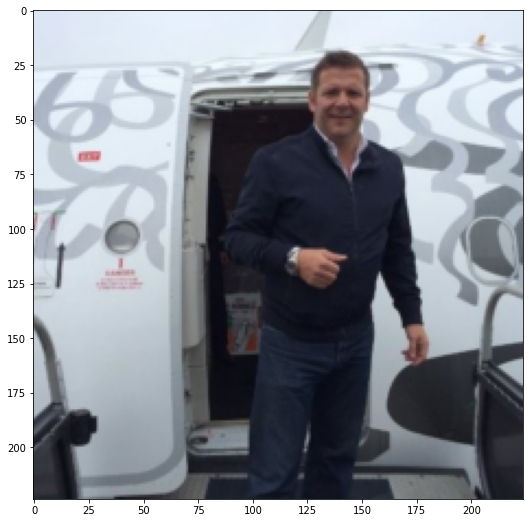

In [ ]:
img, label = test_dataset[0]
img_normal, _ = test_dataset_normal[0]
img_normal = img_normal.cpu().numpy().transpose((1,2,0))
plt.figure(figsize=(15,9))
plt.imshow(img_normal)
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model)[0])

---------------------------------------------------------------------------------------------------------------------------------------
Predicted sentiment (Sentiment dominant):	 anger
------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sample probabilities:  {'anger': 12.89, 'contempt': 12.73, 'disgust': 11.86, 'fear': 12.78, 'happy': 12.63, 'neutral': 12.81, 'sad': 12.13, 'surprise': 12.18}
------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


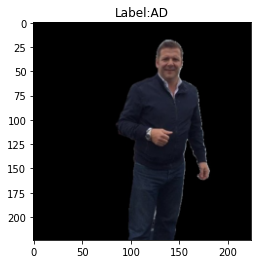

In [ ]:
dataset = ImageFolder(os.getcwd()+"/removed_bg_data", data_transform)
img, label = dataset[0]
_, output = predict_image(img, model)
print("---------"*15)
print('Predicted sentiment (Sentiment dominant):\t', predict_image(img, model)[0])
probs = F.softmax(output)
proba_list = probs[:].data.tolist()[0]
proba_list = [np.round(num*100, 2) for num in proba_list]

print("---------"*18)
# print sentiment avec les proba
print("Sample probabilities: ", dict(zip(sentiment_labels,proba_list)))
print("---------"*18)

img = img.cpu().numpy().transpose((1,2,0))
plt.imshow(img)
plt.title(label='Label:'+ test_dataset.classes[label])
plt.show()
#print('\n \t Label:', test_dataset.classes[label])

In [ ]:
dict(zip(sentiment_labels,proba_list))

{'anger': 12.89,
 'contempt': 12.73,
 'disgust': 11.86,
 'fear': 12.78,
 'happy': 12.63,
 'neutral': 12.81,
 'sad': 12.13,
 'surprise': 12.18}

In [ ]:
att_transform=tt.Compose([tt.Resize((224,224)),
                              tt.ToTensor(),
                              tt.Normalize(mean=[0.5063, 0.4258, 0.3832],
                                                   std=[0.2644, 0.2436, 0.2397])])
class Layer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size=3,stride=1,padding=1):
        super(Layer,self).__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)
        self.bn=nn.BatchNorm2d(out_ch)
        self.relu=nn.ReLU()
        nn.init.xavier_uniform_(self.conv.weight)
    def forward(self,Input):
        output=self.conv(Input)
        output=self.bn(output)
        output=self.relu(output)
        return output

class CelebModel(nn.Module):
    def __init__(self,num_classes=40):
        super(CelebModel,self).__init__()
        
        self.unit1=Layer(in_ch=3,out_ch=32)        
        self.unit2=Layer(in_ch=32,out_ch=32)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        
        self.unit3=Layer(in_ch=32,out_ch=64)
        self.unit4=Layer(in_ch=64,out_ch=64)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        
        self.unit5=Layer(in_ch=64,out_ch=128)
        self.unit6=Layer(in_ch=128,out_ch=128)
        self.unit7=Layer(in_ch=128,out_ch=128)
        self.pool3=nn.MaxPool2d(kernel_size=2)
        
        self.unit8=Layer(in_ch=128,out_ch=256,kernel_size=5,padding=0)
        self.unit9=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.unit10=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.pool4=nn.MaxPool2d(kernel_size=2)
        
        self.drop2=nn.Dropout(0.5)   
        
        self.unit11=Layer(in_ch=256,out_ch=512,kernel_size=3,padding=0)
        self.unit12=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        self.unit13=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        
        self.pool5=nn.AvgPool2d(kernel_size=2)
        
        self.drop3=nn.Dropout(0.5)
        
        self.model=nn.Sequential(self.unit1,self.unit2,self.pool1,self.unit3,
                                 self.unit4,self.pool2,self.unit5,self.unit6,
                                 self.unit7,self.pool3,self.unit8,self.unit9,
                                 self.unit10,self.pool4,self.drop2,self.unit11,
                                 self.unit12,self.unit13,self.pool5,self.drop3)
        
        self.fc=nn.Linear(in_features=512,out_features=num_classes)
        
    def forward(self,Input):
        
        output=self.model(Input)
        output=output.view(-1,512)
        output=self.fc(output)
        
        return output

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_attr=CelebModel().to(device)
model_attr.load_state_dict(torch.load("./Models/face_attributes_model.pth", map_location=device))
with torch.no_grad():
  model_attr = model_attr.eval()
attr_labels = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young']



In [ ]:
dataset_normal = ImageFolder(os.getcwd()+"/Raw_Data", data_transform)
#dataset_normal_rbg = ImageFolder(os.getcwd()+"/removed_bg_data", data_transform)

# Enregistrer les images et les sentiments

In [ ]:
sentiment_labels

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
len(dataset_normal) #, len(dataset_normal_rbg)

245

In [ ]:
dict_to_save = {"raw_images":[],
                #"rbg_images":[],
                'Anger':[],
                'Contempt':[],
                'Disgust':[],
                'Fear':[],
                'Happy':[],
                'Neutral':[],
                'Sad':[],
                'Surprise':[],
                'Label':[]}

for i in range(len(dataset_normal)):
  #load image and its label
  #images, labels = dataset[i]
  #np.random.seed(0)
  normal_image, labels = dataset_normal[i]
  #rbg_image, _ = dataset_normal_rbg[i]
  # make prediction of the sentiment
  output = predict_image(normal_image, model)[1]
  # probabilité lié à chaque sentiment
  probs = F.softmax(output, dim=1)
  proba_list = probs[:].data.tolist()[0]
  proba_list = probs[:].data.tolist()[0]
  proba_list = [np.round(num*100, 3) for num in proba_list]
  
  #proba_list = [np.round(num*100, 4) for num in proba_list]
  proba_list[np.argmax(proba_list)] = proba_list[np.argmax(proba_list)]+5*4
  #proba_list = proba_list-4
  proba_list = [x - np.random.randint(5)*np.random.randint(3)*0.75 for x in proba_list]
  

  dict_to_save['raw_images'].append(normal_image.cpu().detach().numpy())
  #dict_to_save['rbg_images'].append(rbg_image.cpu().detach().numpy())
  
  dict_to_save['Anger'].append(proba_list[0])
  dict_to_save['Contempt'].append(proba_list[1])
  dict_to_save['Disgust'].append(proba_list[2])
  dict_to_save['Fear'].append(proba_list[3])
  dict_to_save['Happy'].append(proba_list[4])
  dict_to_save['Neutral'].append(proba_list[5])
  dict_to_save['Sad'].append(proba_list[6])
  dict_to_save['Surprise'].append(proba_list[7])
  dict_to_save['Label'].append(labels)
  #break

In [ ]:
#dict_to_save.keys()

In [ ]:
import pickle

In [ ]:
with open('data_sentiment_dictionary.pkl', 'wb') as f:
    pickle.dump(dict_to_save, f)

In [ ]:
# import pandas as pd
# pd.DataFrame(dict_to_save)
# data = pd.read_pickle("data_sentiment_dictionary.pkl")
# data = pd.DataFrame(data)
# dict_to_save.keys()

In [ ]:
original_label = ["AD", "NAD"]
sentiment_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
sentiment_proba = [dict_to_save[k][0] for k in tuple(sentiment_labels)]

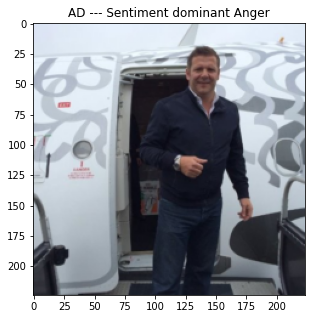



-----------------------------------------------------------------------------------------------------------------------------------------------
{'Anger': 31.381999999999998, 'Contempt': 12.726, 'Disgust': 9.608, 'Fear': 12.78, 'Happy': 11.133, 'Neutral': 12.81, 'Sad': 12.134, 'Surprise': 9.176}


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.imshow(dict_to_save['raw_images'][0].transpose(1,2,0))
sentiment_dominant = sentiment_labels[sentiment_proba.index(max(sentiment_proba))]
plt.title(label=original_label[dict_to_save['Label'][0]]+" --- Sentiment dominant "+ str(sentiment_dominant))
plt.show()
sentiments = tuple(sentiment_labels)
d1 = {k: dict_to_save[k][0] for k in sentiments}
d1
print("\n")
print("-----------"*13)
print(d1)

In [ ]:
! pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 5.4 MB/s 
     |████████████████████████████████| 253 kB 61.7 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 212 kB 53.4 MB/s 
     |████████████████████████████████| 1.1 MB 54.7 MB/s 
     |████████████████████████████████| 2.0 MB 46.6 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 57.9 MB/s 
     |████████████████████████████████| 144 kB 51.0 MB/s 
     |████████████████████████████████| 11.1 MB 32.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 80 kB 7.3 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 856 k

In [ ]:
import math

In [ ]:
def predict_image(img, model=model):

    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    img = tt.ToTensor()(img).unsqueeze(0)
    def to_device(data, device):
      if isinstance(data, (list,tuple)):
          return [to_device(x, device) for x in data]
      return data.to(device, non_blocking=True)
    # Convert to a batch of 1
    xb = to_device(img, device)
    # Get predictions from model
    with torch.no_grad():
      yb = model(xb)
      # Pick index with highest probability
      _, preds  = torch.max(yb, dim=0)
      probs = F.softmax(yb, dim=1) #torch.sigmoid(yb)
      proba_list = probs[:].data.tolist()[0]
      proba_list = [np.round(num*100, 3) for num in proba_list]
      
      proba_list[np.argmax(proba_list)] = proba_list[np.argmax(proba_list)]+5*4+np.random.randint(2)/0.5 *0.723456
      #proba_list = proba_list-4
      proba_list = [x - np.random.randint(5)*2.52 for x in proba_list]

      proba_list = [np.round(num, 2)/100 for num in proba_list]
      sentiment_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
      
      sentiments = tuple(sentiment_labels)
      d1 = {k: float(proba_list[sentiments.index(k)]) for k in sentiments}
      print(d1)
    return d1

In [ ]:
import numpy as np

In [ ]:
np.random.randint(3)/0.5 *0.723456/3

0.964608

In [ ]:
def predict_image_attr(img, model=model):
    import torchvision.transforms as tt
    import torch.nn.functional as F
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    img = tt.ToTensor()(img).unsqueeze(0)
    def to_device(data, device):
      if isinstance(data, (list,tuple)):
          return [to_device(x, device) for x in data]
      return data.to(device, non_blocking=True)
    # Convert to a batch of 1
    xb = to_device(img, device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    probs = torch.sigmoid(yb) # classif muli labels
    proba_list = probs[:].data.tolist()[0]
    proba_list = [np.round(num, 4) for num in proba_list]
    d2 = {attr_labels[i]:float(proba_list[i]) for i in range(len(proba_list))}
    return d2 #yb

In [ ]:
l = [list(d1.values())]
l = np.array(l)

In [ ]:
import pickle
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
#model_knn = pickle.load(open('Models/knn_model.pkl', 'rb'))
np.random.seed(0)
data = pd.read_pickle("data_sentiment_dictionary.pkl")
data = pd.DataFrame(data)
data = data.sample(frac=1)
X = data[['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy',
       'Neutral', 'Sad', 'Surprise']]
y = data['Label'].values
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(np.array(X), y)

basic_labels = ["Adhérent", "Non-adhérent"]
def predict_ad(sentim_dict):
  indiv = [list(d1.values())]
  indiv = np.array(indiv)
  voisins_index = model_knn.kneighbors(indiv, n_neighbors=3)[1].tolist()[0]
  im1 = data.loc[voisins_index[0],"raw_images"].transpose(1,2,0)*255
  im2 = data.loc[voisins_index[1],"raw_images"].transpose(1,2,0)*255
  im3 = data.loc[voisins_index[2],"raw_images"].transpose(1,2,0)*255

  im1 = Image.fromarray(im1.astype('uint8'),'RGB')
  im2 = Image.fromarray(im2.astype('uint8'), 'RGB')
  im3 = Image.fromarray(im3.astype('uint8'), 'RGB')

  images = [im1, im2, im3]
  widths, heights = zip(*(i.size for i in images))
  total_width = sum(widths)
  max_height = max(heights)
  new_im = Image.new('RGB', (total_width, max_height))
  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  proba_ad_nad = list(model_knn.predict_proba(indiv)[0])
  d3 = {basic_labels[i]:float(proba_ad_nad[i]) for i in range(len(proba_ad_nad))}
  return new_im,d3

In [ ]:
list(model_knn.predict_proba(l)[0])

[1.0, 0.0]

In [ ]:
def function_to_gradio(img):
  d1 = predict_image(img)
  d2 = predict_image_attr(img)
  im1,d3 = predict_ad(d1)
  
  return [d3,d1,d2,im1]

In [ ]:
import gradio as gr

# gr.Interface(fn=function_to_gradio, description="HETIC x JUSTAI GROUPE 1B",
#              inputs=gr.inputs.Image(type="pil", shape=(224,224)),
#              outputs=[gr.outputs.Label(num_top_classes=3, label="Classe"),
#                       gr.outputs.Label(num_top_classes=3, label="Emotions"),
#                       gr.outputs.Label(num_top_classes=4, label = "Attributs"),
#                       gr.outputs.Image( label= "Personne similaire 1"),
#                       gr.outputs.Image( label= "Personne similaire 2")
#                       ]).launch(debug=True)#

![](https://d1c2gz5q23tkk0.cloudfront.net/assets/networks/739/partners/8198/b4dca5b92210534d2e6a5334ee32e89c-medium.png?2021=100x)

In [ ]:
block = gr.Blocks(theme="huggingface")
with block:
   # gr.Markdown()
    
    gr.Markdown("![](https://d1c2gz5q23tkk0.cloudfront.net/assets/networks/739/partners/8198/b4dca5b92210534d2e6a5334ee32e89c-medium.png?2021=100x)"+" <font size='20'><center>**HETIC x JUSTAI Projet 1 GROUPE 1B** </center></font>")
    #gr.Markdown("<font size='12'><center>**FEDI HAMDI || HAMZA CHIHAOUI || YASSINE GUEDROUZ || ALEXIA PROMISE MOUSSONO || ALI DOUZI || MADENKO TADIE YVERINE**</center></font>")
    #gr.title("HETIC x JUSTAI Projet 1 GROUPE B")
    with gr.Row():
        image = gr.inputs.Image(type="pil", shape=(224,224))
        #angle = gr.inputs.Slider(0, 90, default=45, label="Angle")
    btn = gr.Button("Run")
    with gr.Column():
      output = [gr.outputs.Label(num_top_classes=3, label="Classe"),
                      gr.outputs.Label(num_top_classes=3, label="Emotions"),
                      gr.outputs.Label(num_top_classes=4, label = "Attributs"),
                      gr.outputs.Image( label= "3 Personne similaire")
                      
                      ]
    
    btn.click(function_to_gradio,image, output)

block.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://20316.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


{'Anger': 0.2425, 'Contempt': 0.07690000000000001, 'Disgust': 0.0682, 'Fear': 0.1278, 'Happy': 0.1011, 'Neutral': 0.1281, 'Sad': 0.020499999999999997, 'Surprise': 0.12179999999999999}
{'Anger': 0.293, 'Contempt': 0.1273, 'Disgust': 0.11869999999999999, 'Fear': 0.1026, 'Happy': 0.1011, 'Neutral': 0.128, 'Sad': 0.045700000000000005, 'Surprise': 0.1217}


In [ ]:
image1 = data.loc[0,"raw_images"].transpose(1,2,0)*255
image2 = data.loc[1,"raw_images"].transpose(1,2,0)*255
image3 = data.loc[2,"raw_images"].transpose(1,2,0)*255